In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot
import matplotlib
#plt.figure(figsize=(8, 6), dpi=150)

Welcome to JupyROOT 6.24/00


In [2]:
templatefile = ROOT.TFile.Open('templates/AD_Templates.root',"READ")
muonfile = ROOT.TFile.Open('AD1_Wet_MuonTracking.root', "READ")

Warning in <TClass::Init>: no dictionary for class TCumulativeMap<string,double> is available
Warning in <TClass::Init>: no dictionary for class TCumulative is available
Warning in <TClass::Init>: no dictionary for class CumulativeData is available


In [3]:
graph_early = templatefile.Get("gPSD_Template_3_0")
graph_late = templatefile.Get("gPSD_Template_0_1")
PSDvE = muonfile.Get("MuonTracking/hPSDvE")

In [4]:
def get_xy_from_TGraph(graph): 
    
    n = graph.GetN()
    
    x = np.asarray([])
    y = np.asarray([])

    for i in range(n): 
        x = np.append(x, graph.GetPointX(i))
        y = np.append(y, graph.GetPointY(i))
        
    return x, y


In [5]:
def waveform_integral(xarray,yarray, intmin, intmax): 
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if intmin<xarray[i]<intmax])
    
    ymin_extra = np.interp(intmin, xarray, yarray)
    ymax_extra = np.interp(intmax, xarray, yarray)
    
    xarraycut = np.concatenate([[intmin],xarraycut,[intmax]])
    yarraycut = np.concatenate([[ymin_extra],yarraycut,[ymax_extra]])
    
    return np.trapz(yarraycut, x=xarraycut)

def get_time(xarray, yarray):
    
    half_max = np.amax(yarray)/2
    
    xarraycut = np.asarray([xarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    yarraycut = np.asarray([yarray[i] for i in range(len(xarray)) if -20<xarray[i]<20])
    
    return np.interp(half_max, yarraycut, xarraycut, left=float('NaN'), right=float('NaN')) 

def get_total_area(xarray,yarray): 
    
    minx = np.amin(xarray)
    maxx = np.amax(xarray)
    
    return waveform_integral(xarray,yarray, intmin=minx, intmax=maxx) 

def get_PSD(xarray, yarray): 
    
    time = get_time(xarray, yarray)
    
    total = waveform_integral(xarray,yarray, intmin=-12+time, intmax=200+time)
    tail  =  waveform_integral(xarray,yarray, intmin=44+time, intmax=200+time)
    
    return tail/total
    
    

In [6]:
x,y = get_xy_from_TGraph(graph_early)
x1, y1 = get_xy_from_TGraph(graph_late)

<Figure size 2100x900 with 0 Axes>

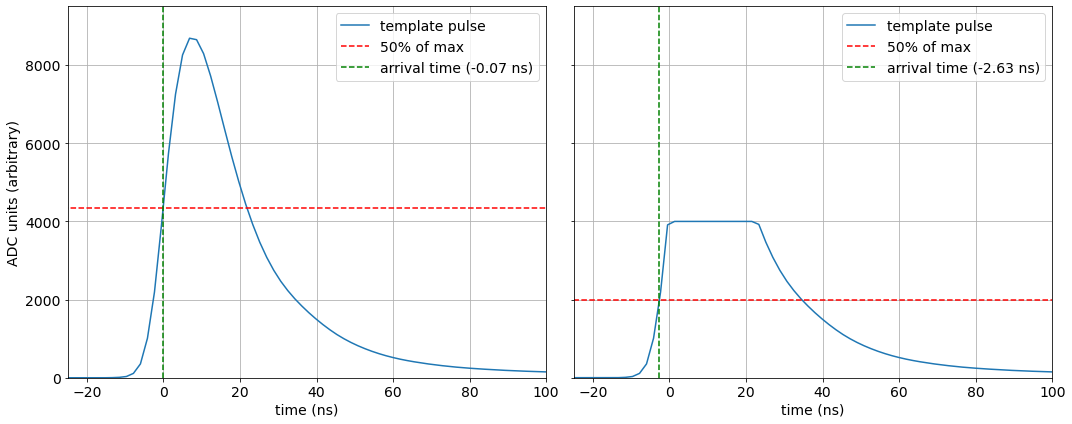

In [16]:
plt.figure(figsize=(14, 6), dpi=150)
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))

ax[0].plot(x,y, linestyle='-', marker='', label='template pulse')
ax[0].plot([x[0],x[-1]], [np.amax(y)/2,np.amax(y)/2], linestyle='--', marker='', color='r', label='50% of max')
ax[0].plot([get_time(x, y), get_time(x, y)], [0,9500], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, y),2)) + ' ns)')
ax[0].grid()
ax[0].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].set_ylim(0,9500)
ax[0].set_xlim(-25, 100)
ax[0].tick_params(axis='both', labelsize=14)

yscaled_clipped = np.copy(y)
clipping_height = 4000
yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height

ax[1].plot(x,yscaled_clipped, linestyle='-', marker='', label='template pulse')
ax[1].plot([x[0],x[-1]], [np.amax(yscaled_clipped)/2,np.amax(yscaled_clipped)/2], linestyle='--', marker='', color='r', label='50% of max')
ax[1].plot([get_time(x, yscaled_clipped), get_time(x, yscaled_clipped)], [0,9500], linestyle='--', color='g', label='arrival time ('+str(np.round(get_time(x, yscaled_clipped),2)) + ' ns)')
ax[1].grid()
ax[1].set_xlabel('time (ns)', fontsize=14); ax[0].set_ylabel('ADC units (arbitrary)', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].set_ylim(0,9500)
ax[1].set_xlim(-25, 100)
ax[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.savefig('fig-template_clipping_example.png')

In [8]:
yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height

In [9]:
def scaling_scan(hmin, hmax, xarray, yarray, clipping_height):
    
    df = pd.DataFrame(columns=['dh', \
                               'scalefactor', \
                               'clipping_height', \
                               'ymax_unclipped', \
                               'ymax_clipped', \
                               'PSD_unclipped', \
                               'PSD_clipped', \
                               'totalarea_unclipped', \
                               'totalarea_clipped', \
                               'time_offset'])
    
    ymax = np.amax(yarray)
    #dh_array = np.arange(hmin, hmax, 300) - ymax
    dh_array = np.linspace(hmin, hmax, 500) - ymax
    
    for dh in dh_array: 
        
        scalefactor = (ymax + dh)/ymax
        
        yscaled = yarray*scalefactor
        yscaled_clipped = np.copy(yscaled)
        
        yscaled_clipped[yscaled_clipped > clipping_height] = clipping_height
        
        dh = dh
        scalefactor = scalefactor
        clipping_height = clipping_height
        ymax_unclipped = np.amax(yscaled)
        ymax_clipped = np.amax(yscaled_clipped)
        PSD_unclipped = get_PSD(xarray, yscaled)
        PSD_clipped = get_PSD(xarray, yscaled_clipped)
        totalarea_unclipped = get_total_area(xarray, yscaled)
        totalarea_clipped = get_total_area(xarray, yscaled_clipped) 
        time_offset = get_time(xarray, yscaled_clipped) - get_time(xarray, yscaled)
        
        df.loc[len(df)] = [dh, \
                           scalefactor, \
                           clipping_height, \
                           ymax_unclipped, \
                           ymax_clipped, \
                           PSD_unclipped, \
                           PSD_clipped, \
                           totalarea_unclipped, \
                           totalarea_clipped, \
                           time_offset]
        
    return df
    

In [10]:
x,y = get_xy_from_TGraph(graph_early)

df_x1 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y))
df_x2 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*2)
df_x3 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*3)
df_x4 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*4)
df_x5 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*5)
df_x6 = scaling_scan(hmin=1, hmax=np.amax(y)*80, xarray=x, yarray=y, clipping_height=np.amax(y)*6)

dfarray = [[df_x1, 1], [df_x2, 2], [df_x3, 3], [df_x4, 4], [df_x5, 5], [df_x6, 6]]

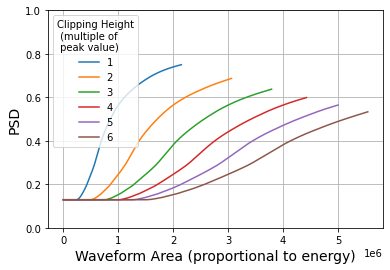

In [11]:
for df in dfarray: 
    plt.plot(np.asarray(df[0]['totalarea_clipped']), np.asarray(df[0]['PSD_clipped']), marker='', linestyle='-', label=str(df[1]))
plt.grid()
plt.legend(title='Clipping Height\n (multiple of  \n peak value)')
plt.ylim(0,1)
plt.xlabel('Waveform Area (proportional to energy)', fontsize=14)
plt.ylabel('PSD', fontsize=14) 
plt.rcParams["figure.figsize"] = (8,6)

In [12]:
sf = 0.000019
ss = 3
vf = 1.00
g1 = ROOT.TGraph( len(df_x1), sf*np.asarray(df_x1['totalarea_clipped'])+ss, vf*np.asarray(df_x1['PSD_clipped']))
g2 = ROOT.TGraph( len(df_x2), sf*np.asarray(df_x2['totalarea_clipped'])+ss, vf*np.asarray(df_x2['PSD_clipped']))
g3 = ROOT.TGraph( len(df_x3), sf*np.asarray(df_x3['totalarea_clipped'])+ss, vf*np.asarray(df_x3['PSD_clipped']))
g4 = ROOT.TGraph( len(df_x4), sf*np.asarray(df_x4['totalarea_clipped'])+ss, vf*np.asarray(df_x4['PSD_clipped']))
g5 = ROOT.TGraph( len(df_x5), sf*np.asarray(df_x5['totalarea_clipped'])+ss, vf*np.asarray(df_x5['PSD_clipped']))
g6 = ROOT.TGraph( len(df_x6), sf*np.asarray(df_x6['totalarea_clipped'])+ss, vf*np.asarray(df_x6['PSD_clipped']))

In [13]:
%jsroot on
c1 = ROOT.TCanvas()
PSDvE.Draw('colz')
PSDvE.GetXaxis().SetRangeUser(0, 150)
PSDvE.GetXaxis().SetTitle("Energy");
PSDvE.GetYaxis().SetTitle("PSD");
#g1.Draw('L'); g1.SetLineColor(2);
#g2.Draw('L'); g2.SetLineColor(2);
#g3.Draw('L'); g3.SetLineColor(2);
#g4.Draw('L'); g4.SetLineColor(2);
g5.Draw('L'); g5.SetLineColor(2);
#g6.Draw('L'); g6.SetLineColor(2);
c1.SetGridx()
c1.SetGridy()
c1.Draw()

Text(0, 0.5, 'time offset (ns)')

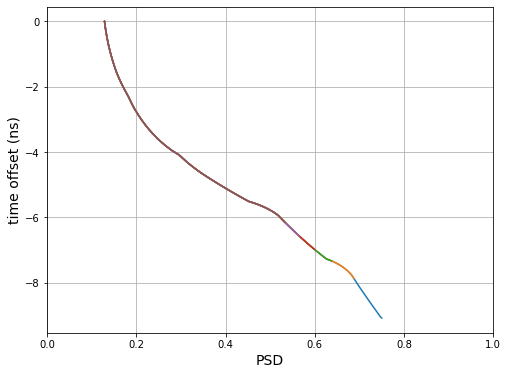

In [14]:
for df in dfarray: 
    plt.plot(np.asarray(df[0]['PSD_clipped']), np.asarray(df[0]['time_offset']), marker='', linestyle='-')
plt.grid()
#plt.legend(title='Clipping Height')
plt.xlim(0,1)
plt.xlabel('PSD', fontsize=14)
plt.ylabel('time offset (ns)', fontsize=14) 

In [15]:
plt.plot(2*np.asarray(df_ch15000['totalarea_clipped']), np.asarray(df_ch15000['PSD_clipped']), marker='', linestyle='-', label='15000')
plt.plot(np.asarray(df_ch30000['totalarea_clipped']), np.asarray(df_ch30000['PSD_clipped']), marker='', linestyle='-', label='30000')

NameError: name 'df_ch15000' is not defined

In [ ]:
intmaxes = np.linspace(100,500,25)
PSD = np.asarray([])

for nums in intmaxes: 
    total = waveform_integral(x,y, intmin=-12, intmax=nums)
    tail = waveform_integral(x,y, intmin=44, intmax=nums)
    PSDval = tail/total
    PSD = np.append(PSD, PSDval)

plt.plot(intmaxes, PSD, linestyle='', marker='o')
plt.grid()
plt.xlabel("Max integration limit for PSD calculation (ns)")
plt.ylabel("PSD")